# How is Topic Related to Genre?

In this notebook we:

- study the relationship between topic and genre, by looking at the distribution of genres of the books belonging to a topic.
- compare different topic models based on filtering terms by different document frequency ranges. 

In [2]:
import glob
import pickle
import os
from collections import Counter

import numpy as np
import pandas as pd
from top2vec import Top2Vec
from tqdm import tqdm


/Users/marijnkoolen/.local/share/virtualenvs/fuzzy-search-KYi4BGOl/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/marijnkoolen/.local/share/virtualenvs/fuzzy-search-KYi4BGOl/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users

## Loading the models

In [18]:
model_dir = '../data/t2v-content_models/'

model_files = glob.glob(os.path.join(model_dir, '*speed_learn*'))

model_range = {}
for mf in model_files:
    parts = mf.split('-')
    model = '-'.join([parts[5].replace('min_df_', ''), parts[6].replace('max_df_', '')])
    print(model)
    model_range[model] = Top2Vec.load(mf)


0.01-0.3
0.001-0.5
0.001-0.1
0.001-0.3
0.01-0.5
0.01-0.1


### Step 2: Extracting the Book-Topic Assignment Information

In [19]:
import numpy as np


data = []


for model in model_range:
    for doc_id, topic in zip(model_range[model].document_ids, model_range[model].doc_top):
        isbn = doc_id.split('_')[-1]
        row = {
            'repr': 'content', 
            'model': model, 
            'isbn': isbn, 
            'topic': topic
        }
        data.append(row)

topic_df = pd.DataFrame(data=data)
topic_df.head(5)

,repr,model,isbn,topic
0,content,0.01-0.3,9789045020860,156
1,content,0.01-0.3,9789403127705,10
2,content,0.01-0.3,9789025440879,17
3,content,0.01-0.3,9789026152412,165
4,content,0.01-0.3,9789021572246,164


## How similar are the models in terms of number of topics and topic size distrubutions?

In [26]:
# nunique gives the number of distinct topic numbers/labels
topic_df.groupby('model').topic.nunique()

model
0.001-0.1    217
0.001-0.3    217
0.001-0.5    235
0.01-0.1     207
0.01-0.3     221
0.01-0.5     228
Name: topic, dtype: int64

All models results in a similar number of topics, with the biggest differences between `0.01-0.1` (the smallest DF range with the smallest number of topics) and `0.001-0.5` (the biggest DF range and the biggest number of topics). 

It seems that a wider DF range results in more topics. This is the inverse of the findings of Sbalchiero and Eder (2020). They found that longer document chunks lead to fewer topics when using LDA for topic modelling. We find that, with a wider DF range, the remaining text per book after filtering is longer, yet the resulting model has more topics. One possible explanation for this difference is that we use Top2Vec, which works fundamentally different from LDA. A wider DF range results in richer representations of texts, and thus possibly to a richer and more diverse latent semantic space, and thereby to more ways for books to differ from each other. Another explanation is that there is confounding effect between text length and word frequency, with longer texts only leading to fewer topics when the extra text per document is sampled from the same document frequency distribution.

- Sbalchiero, S., & Eder, M. (2020). Topic modeling, long texts and the best number of topics. Some Problems and solutions. Quality & Quantity, 54, 1095-1108.

### Comparing the topic size distribtion

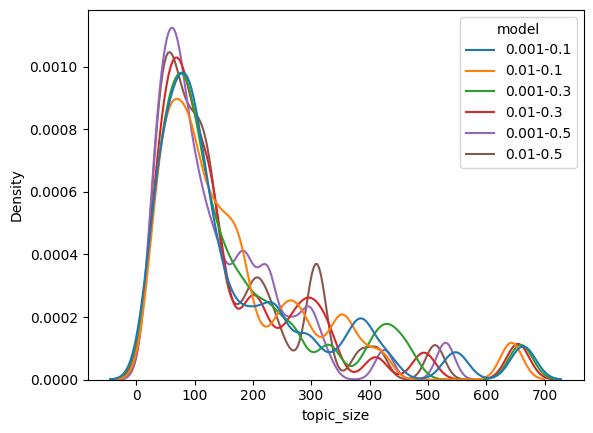

In [31]:
import seaborn as sns

topic_sizes = topic_df.groupby('model').topic.value_counts()
topic_df['topic_size'] = topic_df.apply(lambda row: topic_sizes[(row['model'], row['topic'])], axis=1)

sns.kdeplot(data=topic_df, x='topic_size', hue='model', hue_order=ranges);

In [42]:
topic_df.groupby('model').topic_size.describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
0.001-0.1,19231.0,173.691904,155.382045,20.0,71.0,110.0,234.0,663.0
0.001-0.3,19231.0,168.137018,147.483673,17.0,70.0,109.0,215.0,659.0
0.001-0.5,19231.0,142.868442,111.636154,17.0,63.0,105.0,192.0,530.0
0.01-0.1,19231.0,166.735947,135.415058,18.0,71.0,124.0,226.0,643.0
0.01-0.3,19231.0,161.339140,142.240716,16.0,67.0,111.0,208.0,654.0
0.01-0.5,19231.0,147.834902,115.237697,16.0,63.0,110.0,204.0,512.0


The models are have similar distributions of topic sizes (number of books per topic).

### Selecting a Model for Further Analysis

The model we use for further analysis uses the range `0.01-0.5`, that is, all terms that occur in fewer than 1% of all books or in more than 50% of all books, are removed before topic modelling.
    
The `0.01-0.5` model has the following descriptive statistics:

- The small topic has 16 books, the largest has 512 books. 
- The median number of books per topic is 110. 
- The mean number is 147.8 with a standard deviation of 115.2. In other words, the distribution is skewed. 

## How similar are the clusterings of models with different DF ranges?

When the same set of documents is clustered by multiple models, the similarity of the clusterings can be measured using the [Adjusted Rand Index](https://en.wikipedia.org/wiki/Rand_index). The **normal Rand Index** checks for every pair of documents whether two models agree that the documents belong to a single cluster or not and counts the number of agreements. The **Rand Index** score is the number of agreements divided by the total number of pairs, resulting in a score between 0 (no agreement) and 1 (total agreement). 

Because this does not account for random clusterings sometimes agreeing by chance, the **normal Rand Index* does not reflect how the score for two clusterings differs from the score of two random clusterings (or of one of the model clusterings with a random clustering). To account for chance agreements, the **Adjusted Rand Index** compensates by taking into account how often two random clusterings with the same cluster size distributions as the two model clusterings would agree. This results in a score between -0.5 (complete disagreement), 0 (no better than chance) and 1 (total agremeent).

To understand how filtering on different _Document Frequency ranges_ affects the topic modelling process, we compare the clustersings of models with different _Document Frequency ranges_ using the **Adjusted Rand Index**.

In [22]:
ranges = [
    '0.001-0.1', 
    '0.01-0.1',
    '0.001-0.3', 
    '0.01-0.3', 
    '0.001-0.5', 
    '0.01-0.5', 
]

In [25]:
from itertools import combinations

from sklearn.metrics.cluster import adjusted_rand_score

for df_range1, df_range2 in combinations(ranges, 2):
    ari = adjusted_rand_score(model_range[df_range1].doc_top, model_range[df_range2].doc_top)
    print(f"{df_range1: >10}  {df_range2: >10}\t{ari: >6.2f}")

 0.001-0.1    0.01-0.1	  0.50
 0.001-0.1   0.001-0.3	  0.65
 0.001-0.1    0.01-0.3	  0.56
 0.001-0.1   0.001-0.5	  0.54
 0.001-0.1    0.01-0.5	  0.51
  0.01-0.1   0.001-0.3	  0.54
  0.01-0.1    0.01-0.3	  0.57
  0.01-0.1   0.001-0.5	  0.55
  0.01-0.1    0.01-0.5	  0.58
 0.001-0.3    0.01-0.3	  0.63
 0.001-0.3   0.001-0.5	  0.64
 0.001-0.3    0.01-0.5	  0.59
  0.01-0.3   0.001-0.5	  0.60
  0.01-0.3    0.01-0.5	  0.66
 0.001-0.5    0.01-0.5	  0.65


All ARI scores are above 0.5, which means all models result clustering similarities that are well above chance. Together with the similar numbers of topics and the similar distribution of topic sizes, this is a first signal that topic modelling is not strongly affect by using different document frequency thresholds for filter terms. 

Of course, it could still be that different document frequency ranges result in different relationships between topic and genre. 

## Genre-specificity of clusters

The next step is to investigate how topic relates to genre. We use a book metadata file where Dutch NUR codes have been mapped to a list of 11 genres. 

In [35]:
from impfic_core.map.map_genre import read_genre_file

metadata_file = '../data/work_isbn_title_genre.tsv.gz'

metadata = read_genre_file(metadata_file)
metadata.head(2)

,work_id,record_id,record_id_type,work_year,work_author,work_title,work_length,nur,thema,bisac,brinkman,unesco,nur_genre
0,impfic-work-1,97779,odbr,2010.0,['Ingalill Roos'],['Energievreters -- omgaan met mensen waar je ...,NaN,[770],NaN,NaN,[sociale relaties],"[Sociologie, statistiek]",Non-fiction
1,impfic-work-1,326085068,ppn,2010.0,['Ingalill Roos'],['Energievreters -- omgaan met mensen waar je ...,NaN,[770],NaN,NaN,[sociale relaties],"[Sociologie, statistiek]",Non-fiction


We take the mapped genre label per ISBN and combine it with the topic modelling data:

In [36]:
isbn_genre = metadata[metadata.record_id.isin(topic_df.isbn.unique())][['record_id', 'nur_genre']]
isbn_genre = isbn_genre.rename(columns={'nur_genre': 'genre'})

### The Genre Distribution of Books in the Corpus

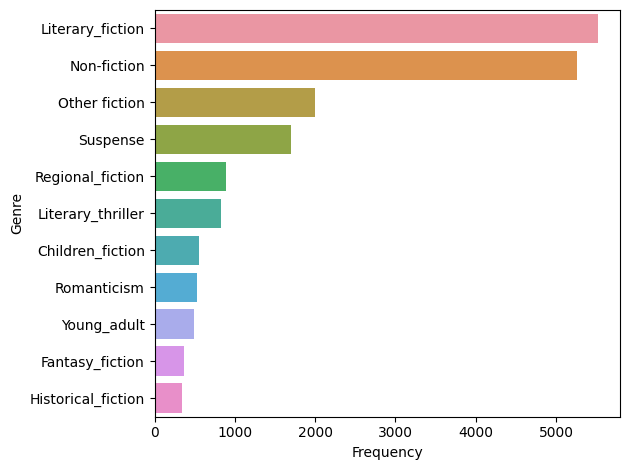

In [151]:
ax = sns.barplot(data=isbn_genre.genre.value_counts().rename('Frequency').reset_index().rename(columns={'index': 'Genre'}), x='Frequency', y='Genre');

ax.figure.tight_layout()
ax.figure.savefig('../images/books_genre_dist.png')

In [37]:

genres = isbn_genre.genre.unique()
genre_frac = (isbn_genre.genre.value_counts() / len(isbn_genre)).rename('frac')
genre_frac

Literary_fiction      0.298890
Non-fiction           0.284538
Other fiction         0.108042
Suspense              0.092066
Regional_fiction      0.047983
Literary_thriller     0.044571
Children_fiction      0.030219
Romanticism           0.028703
Young_adult           0.026807
Fantasy_fiction       0.019767
Historical_fiction    0.018413
Name: frac, dtype: float64

### Computing the Genre Distribution of Books per Topic

In [38]:
topic_df = (pd.merge(topic_df, isbn_genre, left_on='isbn', right_on='record_id')
            .drop('record_id', axis=1))
topic_sizes = topic_df.groupby('model').topic.value_counts()
topic_df['topic_size'] = topic_df.apply(lambda row: topic_sizes[(row['model'], row['topic'])], axis=1)


In [39]:
topic_df.sort_values(['model', 'topic'])

,repr,model,isbn,topic,topic_size,genre
332,content,0.001-0.1,9789023979456,0,663,Non-fiction
554,content,0.001-0.1,9789403116600,0,663,Other fiction
560,content,0.001-0.1,9789021144665,0,663,Non-fiction
566,content,0.001-0.1,9789023956747,0,663,Non-fiction
704,content,0.001-0.1,9789023929086,0,663,Non-fiction
...,...,...,...,...,...,...
92092,content,0.01-0.5,9789020530957,227,16,Regional_fiction
92728,content,0.01-0.5,9789020519150,227,16,Regional_fiction
95398,content,0.01-0.5,9789401909006,227,16,Regional_fiction
97060,content,0.01-0.5,9789020531541,227,16,Regional_fiction


In [44]:
target_model = '0.01-0.5'
models = list(topic_df.model.unique())
model_df = topic_df[topic_df.model == target_model]


In [46]:
model_df = topic_df[topic_df.model == target_model]
topic_genre_freq = (model_df.groupby(['topic', 'topic_size'])
                    .genre
                    .value_counts()
                    .rename('freq'))

topic_genre_freq.unstack().fillna(0.0).reset_index('topic_size')

genre,topic_size,Children_fiction,Fantasy_fiction,Historical_fiction,Literary_fiction,Literary_thriller,Non-fiction,Other fiction,Regional_fiction,Romanticism,Suspense,Young_adult
topic,,,,,,,,,,,,
0,512,0.0,0.0,0.0,420.0,22.0,8.0,49.0,0.0,2.0,4.0,7.0
1,415,0.0,0.0,0.0,0.0,0.0,405.0,10.0,0.0,0.0,0.0,0.0
2,383,1.0,0.0,1.0,246.0,56.0,1.0,6.0,0.0,26.0,30.0,16.0
3,320,0.0,0.0,2.0,38.0,5.0,4.0,37.0,230.0,0.0,3.0,1.0
4,311,0.0,0.0,0.0,0.0,0.0,305.0,6.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
223,22,13.0,0.0,0.0,4.0,0.0,2.0,1.0,0.0,0.0,0.0,2.0
224,20,0.0,0.0,0.0,17.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
225,20,1.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


From eyeballing these genre frequencies, it seems that many individual topics have a dominant genre.

### Determining the Genre Dominance of a Topic

What is the majority genre per topic?

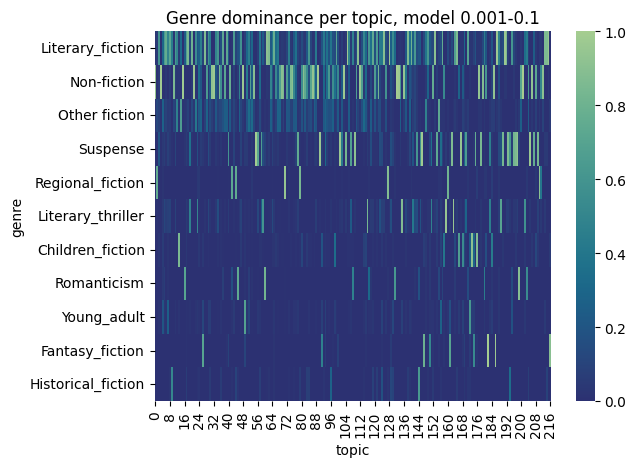

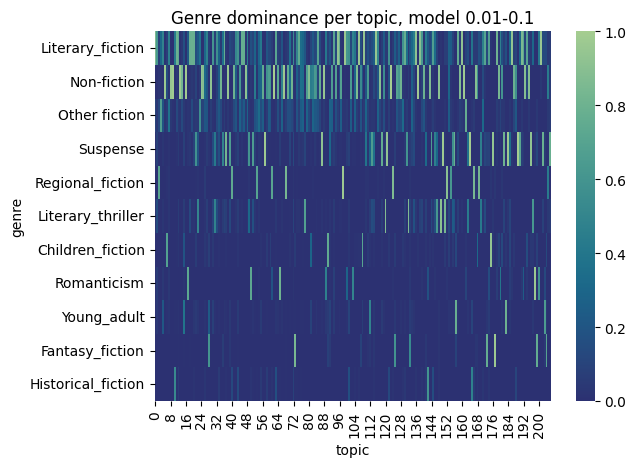

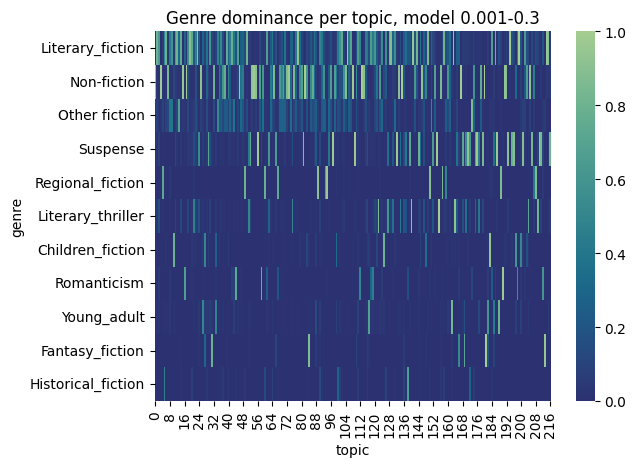

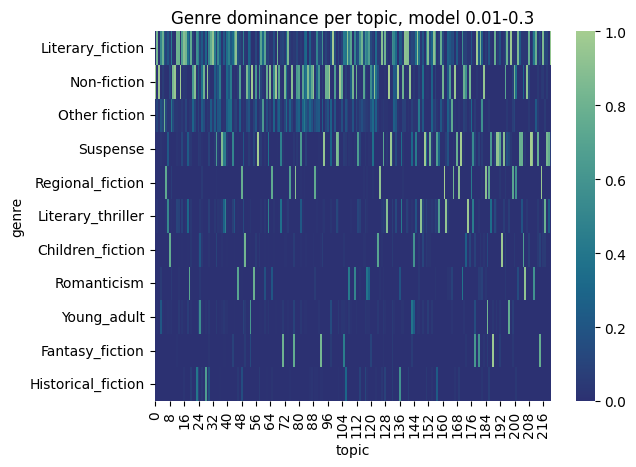

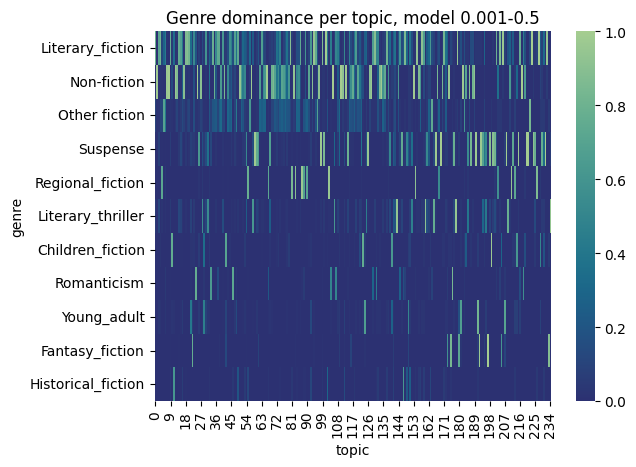

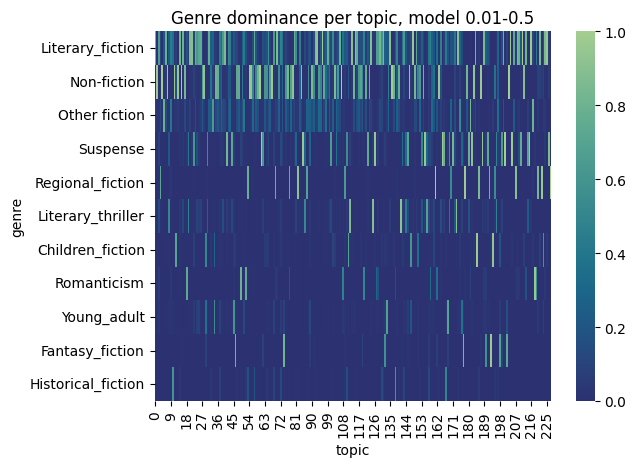

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from scipy.special import kl_div

sns.color_palette("crest", as_cmap=True)


def select_model(topic_df, model_name):
    return topic_df[topic_df.model == model_name]


def calculate_topic_genre_frac(model_df, model_name):
    model_df = (model_df.groupby(['topic', 'topic_size'])
                .genre
                .value_counts()
                .rename('freq'))

    topic_genre_freq = model_df.unstack().fillna(0.0).reset_index('topic_size')
    topic_genre_frac = (topic_genre_freq[genre_frac.index]
                        .T
                        .div(topic_genre_freq.topic_size, axis=1)
                        .T)
    topic_genre_frac['model'] = model_name
    return topic_genre_frac
    

topic_genre_frac = pd.concat([calculate_topic_genre_frac(select_model(topic_df, model_name), model_name) for model_name in models])

for model in ranges:
    fig, ax = plt.subplots()
    ax = sns.heatmap(topic_genre_frac[topic_genre_frac.model == model].drop('model', axis=1).T, cmap='crest_r');
    ax.set_title(f'Genre dominance per topic, model {model}');



The heatmaps show per topic what fraction of books belong to each genre, with lighter colours indicating larger fractions and darker colours indicating lower fractions. For instance, across all models, topic 0 has no books in the genres _Literary thriller_, _Children's fiction_, _Romanticism_, _Young Adult_, _Fantasy fiction_ nor _Historical fiction_.

A distribution plot of the per-topic fraction represented by the most common genre in that topic, shows that most topics have genre that represented more than 50% of all books. While over the entire collection, the dominant genre is Literary fiction, which represents 29% of all books. 

It looks like all models have a strong relationship between topic and genre. For most topics, the vast majority of books in that topic belong to a single genre. But the genre distribution of the entire collection is also highly skewed, with a few very large genres and many much smaller genres. So perhaps the skew in most topics resembles the background genre distribution of the collection.

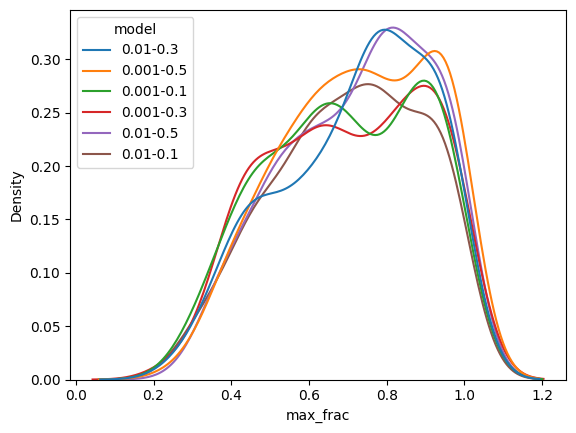

In [61]:
topic_genre_frac['max_frac'] = topic_genre_frac[genres].apply(lambda row: max(row), axis=1)

sns.kdeplot(data=topic_genre_frac, x='max_frac', hue='model');

In [64]:
from itertools import combinations

from scipy import stats

for model1, model2 in combinations(ranges, 2):
    stat = stats.ks_2samp(topic_genre_frac[topic_genre_frac.model == model1].max_frac,
                          topic_genre_frac[topic_genre_frac.model == model2].max_frac)
    print(f"{model1: >10}  {model2: >10}\t{stat.pvalue: >6.2f}")

 0.001-0.1    0.01-0.1	  0.86
 0.001-0.1   0.001-0.3	  0.98
 0.001-0.1    0.01-0.3	  0.09
 0.001-0.1   0.001-0.5	  0.45
 0.001-0.1    0.01-0.5	  0.16
  0.01-0.1   0.001-0.3	  0.75
  0.01-0.1    0.01-0.3	  0.48
  0.01-0.1   0.001-0.5	  0.47
  0.01-0.1    0.01-0.5	  0.32
 0.001-0.3    0.01-0.3	  0.14
 0.001-0.3   0.001-0.5	  0.45
 0.001-0.3    0.01-0.5	  0.22
  0.01-0.3   0.001-0.5	  0.68
  0.01-0.3    0.01-0.5	  0.89
 0.001-0.5    0.01-0.5	  0.88


Using a $\alpha=0.05$ significanec threshold, there is no pair of the models that differ significantly in their distributions of the fractions of the majority topics.

### KL-Divergence in Genre Distribution Between Topic and Collection

To establish the extent to with the genre distribution in a topic diverges from the topic distribution of the collection, we measure KL-divergence. If the distributions are very similar, we expect a KL-divergence score close to 0. In theory, the maximum score is positive infinity, but in practice, scores above 10.0 are rare.

In [73]:
def calculate_kld(topic_genre_frac, model_name, coll_genre_frac):
    #print(topic_genre_frac.columns)
    #print(coll_genre_frac.index)
    drop_cols = ['model', 'max_frac'] if 'max_frac' in topic_genre_frac.columns else ['model']
    genre_kl_div = (topic_genre_frac[topic_genre_frac.model == model_name]
                    .drop(drop_cols, axis=1)
                    .apply(lambda row: entropy(row, coll_genre_frac), axis=1)
                    .rename('kl_div'))
    genre_kl_div = genre_kl_div.reset_index().rename(columns={'index': 'topic'})
    genre_kl_div['model_name'] = model_name
    return genre_kl_div[['model_name', 'topic', 'kl_div']]
    

genre_kl_div = pd.concat([calculate_kld(topic_genre_frac, model_name, genre_frac) for model_name in models])
genre_kl_div

,model_name,topic,kl_div
0,0.01-0.3,0,1.083118
1,0.01-0.3,1,0.750557
2,0.01-0.3,2,1.158302
3,0.01-0.3,3,0.764369
4,0.01-0.3,4,0.619936
...,...,...,...
202,0.01-0.1,202,1.624840
203,0.01-0.1,203,2.172455
204,0.01-0.1,204,2.580714
205,0.01-0.1,205,1.018128


Next, we compare the distributions of KL-divergence scores of the six models:

In [74]:
genre_kl_div.groupby('model_name').kl_div.describe()

,count,mean,std,min,25%,50%,75%,max
model_name,,,,,,,,
0.001-0.1,217.0,1.161511,0.775021,0.162912,0.577660,0.974866,1.599469,3.923735
0.001-0.3,217.0,1.233925,0.780456,0.169664,0.641412,1.004932,1.776330,3.923735
0.001-0.5,235.0,1.285586,0.780507,0.172641,0.681110,1.049652,1.884555,3.923735
0.01-0.1,207.0,1.186324,0.744343,0.157803,0.632276,0.988505,1.659424,3.756961
0.01-0.3,221.0,1.266495,0.758072,0.192992,0.701588,1.026742,1.841261,3.775154
0.01-0.5,228.0,1.265683,0.763234,0.209984,0.681879,1.064305,1.765029,3.771410


All six models show similar _mean_, _minimum_, _maximum_ and _median_ (the _50%_ column) scores, suggesting they all diviate in the same way, and have similar relationships between topic and genre. 

But whether these deviations are small or large is difficult to read from the numbers themselves. For that, we should compare them against clustering the books in clusters of the same sizes, but using a random assignment. For large topics (with many books), a random clustering should have a genre distribution close to that of the collection. For small clusters the divergence tends to be higher.

We create 5 alternative clusterings with books randomly assigned to topics with the same topic size distribution as our target model `0.01-0.5`.

In [80]:
def make_random_topic_genre_frac(model_df):
    return pd.DataFrame(data={
        'topic': list(model_df.topic), 
        'topic_size': list(model_df.topic_size), 
        'genre': list(model_df.genre.sample(frac=1))})


random_genre_klds = []
for trial in range(5):
    random_model_df = make_random_topic_genre_frac(topic_df[topic_df.model==target_model])
    random_genre_frac = calculate_topic_genre_frac(random_model_df, f'rand_{trial}')
    random_genre_kld = calculate_kld(random_genre_frac, f'rand_{trial}', genre_frac)
    topic_size = random_model_df[['topic', 'topic_size']].drop_duplicates().set_index('topic')
    random_genre_kld['topic_size'] = random_genre_kld.topic.apply(lambda x: topic_size.loc[x])
    random_genre_klds.append(random_genre_kld)

random_genre_kld = pd.concat(random_genre_klds)

Next, we calculate descriptive statistics of the random models and the target model in terms of KL-divergence of per-topic genre distributions.

In [139]:
target_genre_kld = genre_kl_div[genre_kl_div.model_name == target_model]
compare_kld = pd.concat([random_genre_kld, target_genre_kld])
compare_kld.groupby('model_name').kl_div.describe().T

model_name,0.01-0.5,rand_0,rand_1,rand_2,rand_3,rand_4
count,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000
mean,1.265683,0.104823,0.103253,0.107054,0.103338,0.105024
std,0.763234,0.074612,0.074397,0.080094,0.073099,0.083453
min,0.209984,0.009524,0.005347,0.005389,0.006674,0.006431
25%,0.681879,0.048928,0.043930,0.044760,0.053229,0.042698
50%,1.064305,0.085399,0.089094,0.086163,0.085718,0.084251
75%,1.765029,0.152361,0.144954,0.153071,0.139354,0.144500
max,3.771410,0.366491,0.502443,0.456099,0.467034,0.484870


We can also make density plots of these models to show that the random assignments lead to distributions that are very similar to each other, but very different (much more density at the lower KL-divergence scores) than the target model. 

In [98]:
compare_kld[compare_kld.model_name == 'rand_0']

,model_name,topic,kl_div,topic_size
0,rand_0,0,0.014267,512.0
1,rand_0,1,0.017515,415.0
2,rand_0,2,0.014966,383.0
3,rand_0,3,0.012118,320.0
4,rand_0,4,0.012665,311.0
...,...,...,...,...
223,rand_0,223,0.171066,22.0
224,rand_0,224,0.330158,20.0
225,rand_0,225,0.279954,20.0
226,rand_0,226,0.300878,16.0


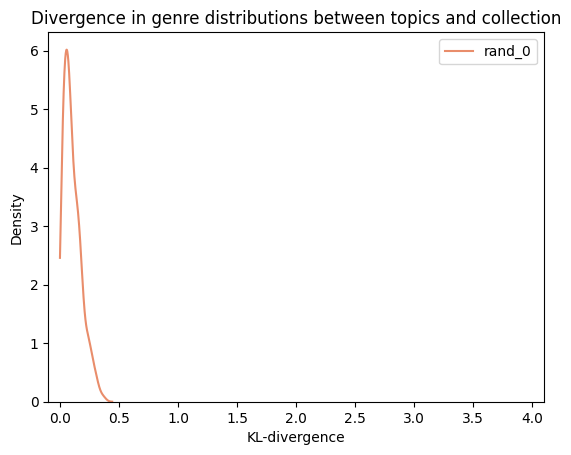

In [133]:
compare_kld['model_name'] = compare_kld.model_name.apply(lambda x: 'model' if x == '0.01-0.5' else x)

colors = sns.color_palette('flare', 6)

fig, ax = plt.subplots()

for mi, model in enumerate(compare_kld.model_name.unique()):
    if model != 'rand_0':
        continue
    color = colors[mi]
    sns.kdeplot(data=compare_kld[compare_kld.model_name == model], x='kl_div', clip=(0, 4), label=model, color=color);

ax.legend()
ax.set_xlabel('KL-divergence')
ax.set_xlim((-0.1, 4.1))
ax.set_title('Divergence in genre distributions between topics and collection');

ax.figure.savefig('../images/genre_topic/genre_dist-kl_div-rand_0_only.png', dpi=150)

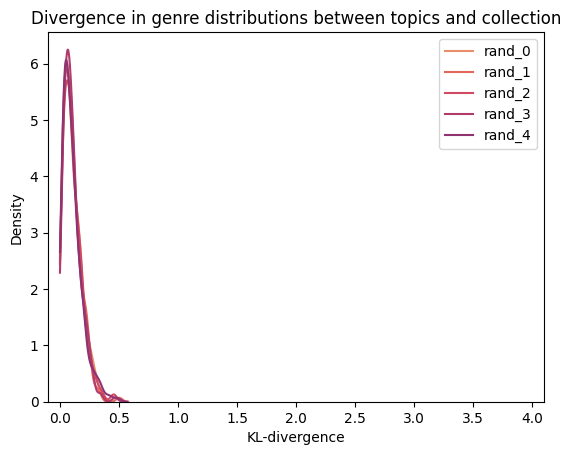

In [132]:
fig, ax = plt.subplots()

for mi, model in enumerate(compare_kld.model_name.unique()):
    if model == 'model':
        continue
    color = colors[mi]
    sns.kdeplot(data=compare_kld[compare_kld.model_name == model], x='kl_div', clip=(0, 4), label=model, color=color);

ax.legend()
ax.set_xlabel('KL-divergence')
ax.set_xlim((-0.1, 4.1))
ax.set_title('Divergence in genre distributions between topics and collection');


ax.figure.savefig('../images/genre_topic/genre_dist-kl_div-rand_only.png', dpi=150)

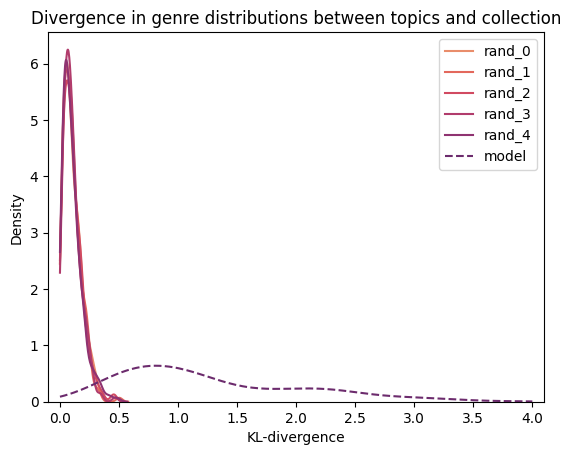

In [127]:
compare_kld['model_name'] = compare_kld.model_name.apply(lambda x: 'model' if x == '0.01-0.5' else x)

colors = sns.color_palette('flare', 6)

fig, ax = plt.subplots()

for mi, model in enumerate(compare_kld.model_name.unique()):
    ls = '--' if model == 'model' else '-'
    color = colors[mi]
    sns.kdeplot(data=compare_kld[compare_kld.model_name == model], x='kl_div', clip=(0, 4), linestyle=ls, label=model, color=color);

ax.legend()
ax.set_xlabel('KL-divergence')
ax.set_xlim((-0.1, 4.1))
ax.set_title('Divergence in genre distributions between topics and collection');

ax.figure.savefig('../images/genre_topic/genre_dist-kl_div.png', dpi=150)

First, we do a quantitative analysis of the relationship between topic and genre. Each topic is associated with a number of books and thereby with the same number of genre labels. From eyeballing the distribution of genre labels per topic, it seems that for most topics, the vast majority of books in that topic belong to a single genre. But the genre distribution of the entire collection is also highly skewed, with a few very large genres and many much smaller genres. So perhaps the skew in most topics resembles the skew of the background genre distribution of the collection. 

To measure how much the genre distribution per topic deviates from that of the collection, we compute the KL-divergence between the two distributions. This gives a set of 228 deviations from collection distribution.

But whether these deviations are small or large is difficult to read from the numbers themselves. For that, we should compare them against a random clustering of the books in clusters of the same sizes. For large topics (with many books), a random clustering should have a genre distribution close to that of the collection. For small clusters the divergence tends to be higher.

We create 5 alternative clusterings with books randomly assigned to topics with the same topic size distribution as established by the topic model. The distribution of the 228 KL-divergence scores per model (5 random and one topic model) are shown in Figure~\ref{fig:genre_kl_div}. The five random models have almost identical distributions concentrated around 0.1 with a standard deviation around 0.075 and a max of around 0.5. The genre distribution of the topic model is very different, with  a median score of 1.06 and more than 75\% of all scores above 0.68.

From this quantitative analysis, it is clear that there is a strong relationship between topic and genre.

The KL-divergence distributions of the six models are very similar to each other:

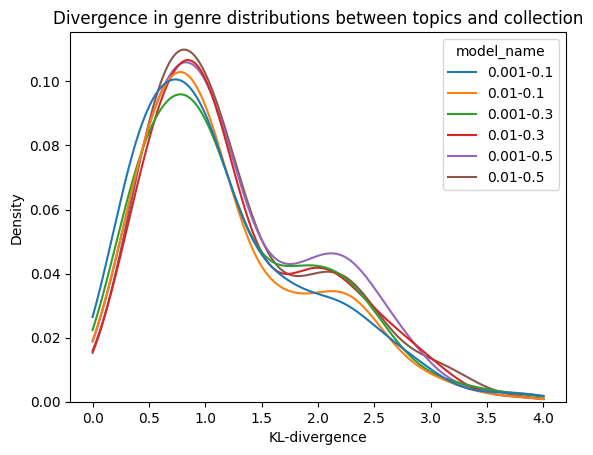

In [95]:
import seaborn as sns


ax = sns.kdeplot(data=genre_kl_div, x='kl_div', hue='model_name', hue_order=ranges, clip=(0.0, 4.0));
ax.set_xlabel('KL-divergence')
ax.set_title('Divergence in genre distributions between topics and collection');


A 2-sample Kolmogorov-Smirnov test for significant differences between the distributions of the models shows that there are no pairs with significantly different distributions for $\alpha = 0.05$.

In [94]:
from itertools import combinations

from scipy import stats

for model1, model2 in combinations(ranges, 2):
    stat = stats.ks_2samp(genre_kl_div[genre_kl_div.model_name == model1].kl_div,
                          genre_kl_div[genre_kl_div.model_name == model2].kl_div)
    print(f"{model1: >10}  {model2: >10}\t{stat.pvalue: >6.2f}")


 0.001-0.1    0.01-0.1	  0.57
 0.001-0.1   0.001-0.3	  0.68
 0.001-0.1    0.01-0.3	  0.27
 0.001-0.1   0.001-0.5	  0.23
 0.001-0.1    0.01-0.5	  0.23
  0.01-0.1   0.001-0.3	  0.91
  0.01-0.1    0.01-0.3	  0.53
  0.01-0.1   0.001-0.5	  0.51
  0.01-0.1    0.01-0.5	  0.40
 0.001-0.3    0.01-0.3	  0.45
 0.001-0.3   0.001-0.5	  0.90
 0.001-0.3    0.01-0.5	  0.54
  0.01-0.3   0.001-0.5	  0.99
  0.01-0.3    0.01-0.5	  1.00
 0.001-0.5    0.01-0.5	  0.98
